In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


In [ ]:
#Kaggle credentials for using the kaggle API
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=896a1edc354031a051a6fa8c03e2975de7005ba77d5f9ed790ec03c31b03b39b
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [ ]:
#Kaggle Api for downloading datasets
!kaggle competitions download -c osic-pulmonary-fibrosis-progression

100% 13.3G/13.3G [05:30<00:00, 29.7MB/s]
100% 13.3G/13.3G [05:30<00:00, 43.4MB/s]


In [ ]:
#unzip files
!find . -depth -name '*.zip' -exec /usr/bin/unzip -n {} \; -exec rm {} \;

Streaming output truncated to the last 5000 lines.
  inflating: train/ID00370637202296737666151/14.dcm  
  inflating: train/ID00370637202296737666151/140.dcm  
  inflating: train/ID00370637202296737666151/141.dcm  
  inflating: train/ID00370637202296737666151/142.dcm  
  inflating: train/ID00370637202296737666151/143.dcm  
  inflating: train/ID00370637202296737666151/144.dcm  
  inflating: train/ID00370637202296737666151/145.dcm  
  inflating: train/ID00370637202296737666151/146.dcm  
  inflating: train/ID00370637202296737666151/147.dcm  
  inflating: train/ID00370637202296737666151/148.dcm  
  inflating: train/ID00370637202296737666151/149.dcm  
  inflating: train/ID00370637202296737666151/15.dcm  
  inflating: train/ID00370637202296737666151/150.dcm  
  inflating: train/ID00370637202296737666151/151.dcm  
  inflating: train/ID00370637202296737666151/152.dcm  
  inflating: train/ID00370637202296737666151/153.dcm  
  inflating: train/ID00370637202296737666151/154.dcm  
  inflating: tra

In [ ]:
# Libraries that need to be installed
!pip install pydicom

     |████████████████████████████████| 35.5MB 89kB/s 


#1. Why do we do this?
Pulmonary = lung | fibrosis = scar tissue => Scarring in the lungs. Over time, scarring can destroy the normal lung and make it hard for oxygen to get into your blood. Pulmonary fibrosis isn’t just one disease. It is a family of more than 200 different lung diseases that all look very much alike.




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


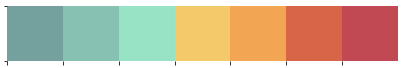

In [ ]:
#Libraries used 
# Regular Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from scipy.stats import pearsonr

import pydicom # for DICOM images
from skimage.transform import resize
import copy
import re

# Segmentation
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import warnings
warnings.filterwarnings("ignore")


# Set Color Palettes for the notebook
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

In [ ]:
# Import train + test data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

# Train len
print("Total Recordings in Train Data: {:,}".format(len(train)))


print("Q: Are there any missing values?", "\n" +
      "A: {}".format(train.isnull().values.any()))

Total Recordings in Train Data: 1,549
Q: Are there any missing values? 
A: False


There are 176 unique patients in Train Data. 

Minimum number of entries are: 6 
Maximum number of entries are: 10


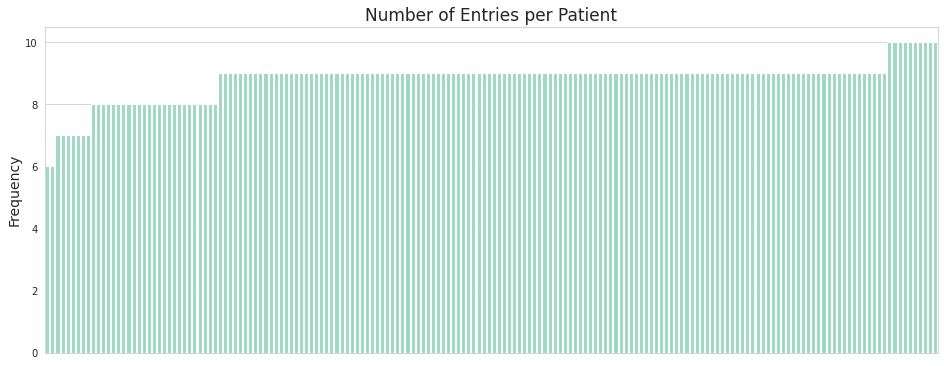

In [ ]:
print("There are {} unique patients in Train Data.".format(len(train["Patient"].unique())), "\n")

# Recordings per Patient
data = train.groupby(by="Patient")["Weeks"].count().reset_index(drop=False)
# Sort by Weeks
data = data.sort_values(['Weeks']).reset_index(drop=True)
print("Minimum number of entries are: {}".format(data["Weeks"].min()), "\n" +
      "Maximum number of entries are: {}".format(data["Weeks"].max()))

# Plot
plt.figure(figsize = (16, 6))
p = sns.barplot(data["Patient"], data["Weeks"], color=custom_colors[2])

plt.title("Number of Entries per Patient", fontsize = 17)
plt.xlabel('Patient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

p.axes.get_xaxis().set_visible(False);

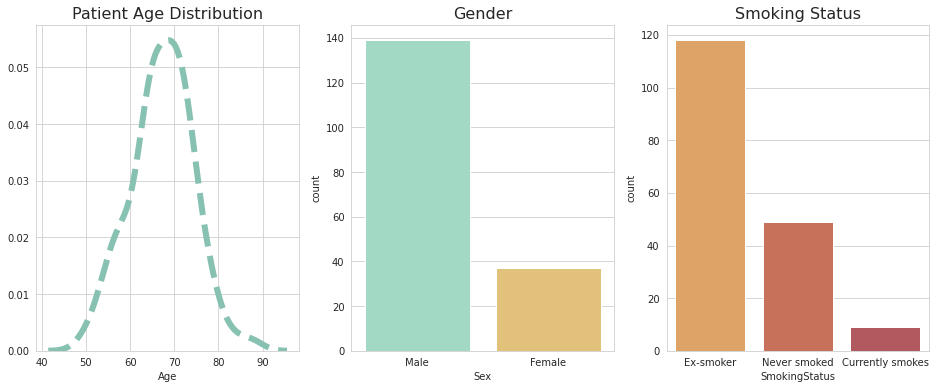

In [ ]:
# Select unique bio info for the patients
data = train.groupby(by="Patient")[["Patient", "Age", "Sex", "SmokingStatus"]].first().reset_index(drop=True)

# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.distplot(data["Age"], ax=ax1, color=custom_colors[1], hist=False, kde_kws=dict(lw=6, ls="--"))
b = sns.countplot(data["Sex"], ax=ax2, palette=custom_colors[2:4])
c = sns.countplot(data["SmokingStatus"], ax=ax3, palette = custom_colors[4:7])

a.set_title("Patient Age Distribution", fontsize=16)
b.set_title("Gender", fontsize=16)
c.set_title("Smoking Status", fontsize=16);

Min FVC value: 827 
Max FVC value: 6,399 

Min Percent value: 28.88% 
Max Percent value: 153.1%


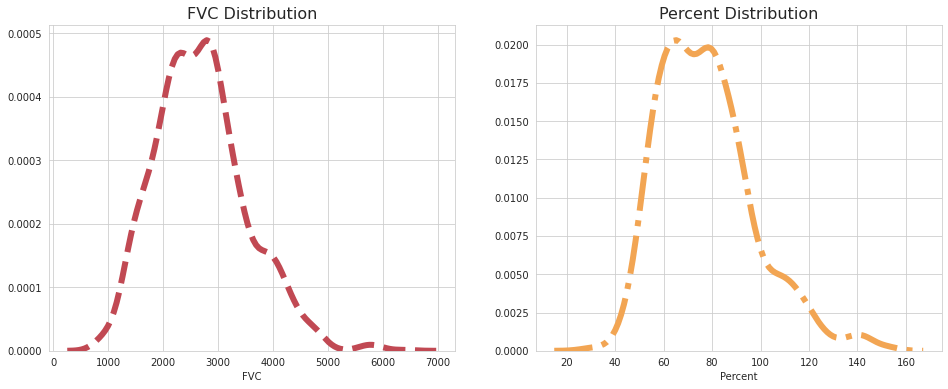

In [ ]:
"""
FVC the recorded lung capacity in ml (how much air you can exhale
in a maximal forced expiration effort)
Percent a computed field which approximates the patient's FVC as a percent
of the typical FVC for a person of similar characteristics

📌Remember:
FVC: most values lie between 1,000 and 5,000 ml.
There are also some very high outliers above 5,000 and little values 
that lie below 1,000.
Percent: more than ~80% of the patients scored below 100%.
"""
print("Min FVC value: {:,}".format(train["FVC"].min()), "\n" +
      "Max FVC value: {:,}".format(train["FVC"].max()), "\n" +
      "\n" +
      "Min Percent value: {:.4}%".format(train["Percent"].min()), "\n" +
      "Max Percent value: {:.4}%".format(train["Percent"].max()))

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.distplot(train["FVC"], ax=ax1, color=custom_colors[6], hist=False, kde_kws=dict(lw=6, ls="--"))
b = sns.distplot(train["Percent"], ax=ax2, color=custom_colors[4], hist=False, kde_kws=dict(lw=6, ls="-."))

a.set_title("FVC Distribution", fontsize=16)
b.set_title("Percent Distribution", fontsize=16);


Minimum no. weeks before CT: -5 
Maximum no. weeks after CT: 133


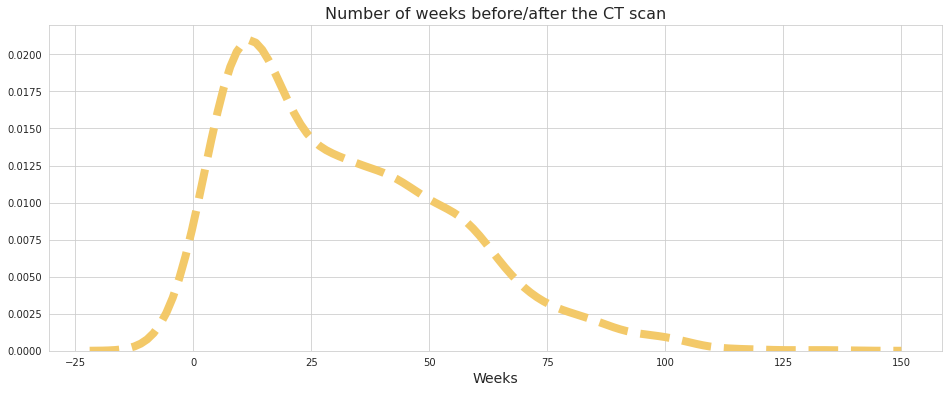

In [ ]:
print("Minimum no. weeks before CT: {}".format(train['Weeks'].min()), "\n" +
      "Maximum no. weeks after CT: {}".format(train['Weeks'].max()))

plt.figure(figsize = (16, 6))

a = sns.distplot(train['Weeks'], color=custom_colors[3], hist=False, kde_kws=dict(lw=8, ls="--"))
plt.title("Number of weeks before/after the CT scan", fontsize = 16)
plt.xlabel("Weeks", fontsize=14);

Pearson Corr FVC x Percent: 0.672 
Pearson Corr FVC x Age: -0.09 
Pearson Corr Percent x Age: 0.096


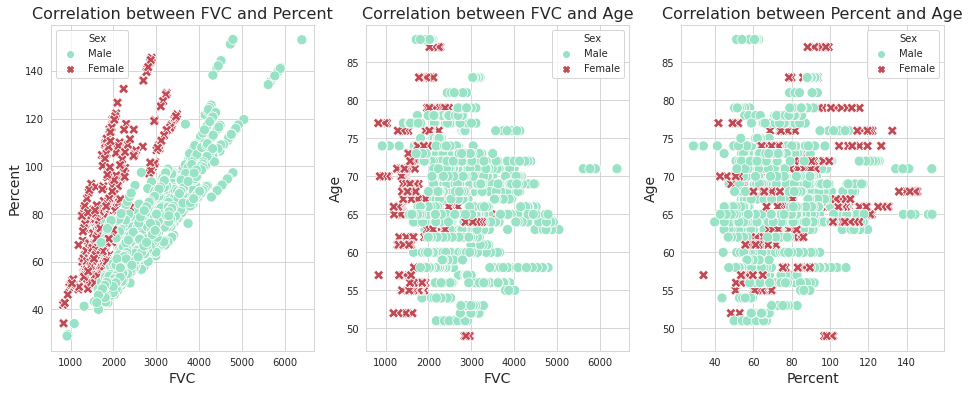

In [ ]:
# Compute Correlation
corr1, _ = pearsonr(train["FVC"], train["Percent"])
corr2, _ = pearsonr(train["FVC"], train["Age"])
corr3, _ = pearsonr(train["Percent"], train["Age"])
print("Pearson Corr FVC x Percent: {:.4}".format(corr1), "\n" +
      "Pearson Corr FVC x Age: {:.0}".format(corr2), "\n" +
      "Pearson Corr Percent x Age: {:.2}".format(corr3))

# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.scatterplot(x = train["FVC"], y = train["Percent"], palette=[custom_colors[2], custom_colors[6]],
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax1)

b = sns.scatterplot(x = train["FVC"], y = train["Age"], palette=[custom_colors[2], custom_colors[6]],
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax2)

c = sns.scatterplot(x = train["Percent"], y = train["Age"], palette=[custom_colors[2], custom_colors[6]],
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax3)

a.set_title("Correlation between FVC and Percent", fontsize = 16)
a.set_xlabel("FVC", fontsize = 14)
a.set_ylabel("Percent", fontsize = 14)

b.set_title("Correlation between FVC and Age", fontsize = 16)
b.set_xlabel("FVC", fontsize = 14)
b.set_ylabel("Age", fontsize = 14)

c.set_title("Correlation between Percent and Age", fontsize = 16)
c.set_xlabel("Percent", fontsize = 14)
c.set_ylabel("Age", fontsize = 14);

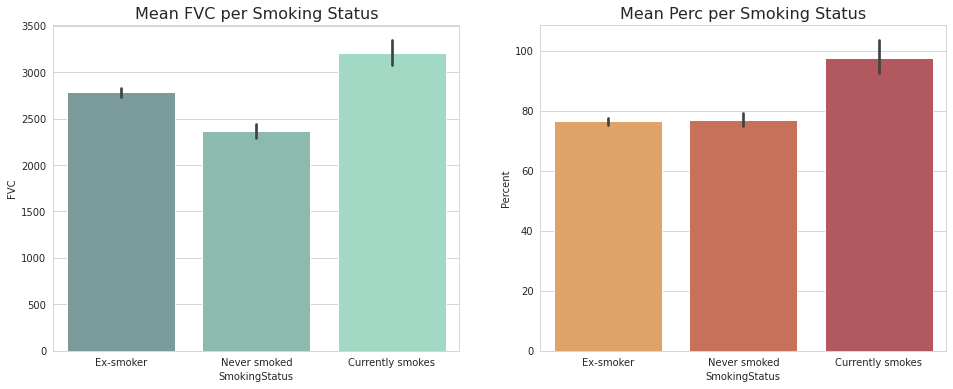

In [ ]:
# Figure
f, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

a = sns.barplot(x = train["SmokingStatus"], y = train["FVC"], ax=ax1, palette=custom_colors[0:4])
b = sns.barplot(x = train["SmokingStatus"], y = train["Percent"], ax=ax2, palette=custom_colors[4:7])

a.set_title("Mean FVC per Smoking Status", fontsize=16)
b.set_title("Mean Perc per Smoking Status", fontsize=16);

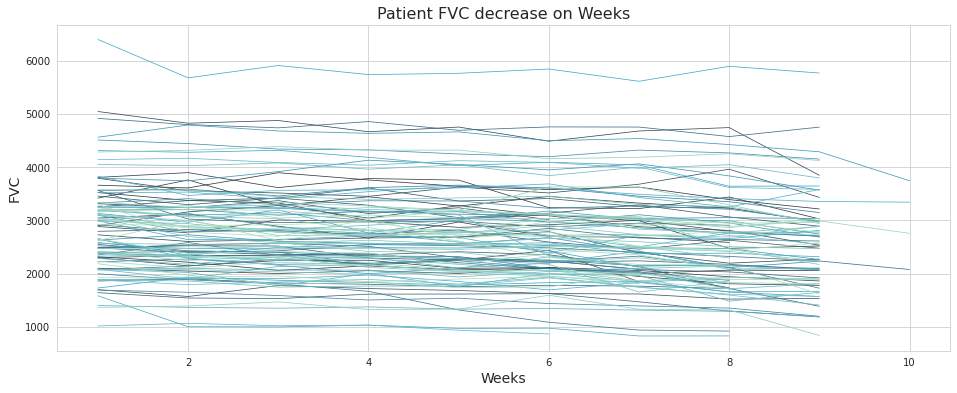

In [ ]:
#Create Time variable to count in ascending order the times the
#Patient has done a check in FVC
data_time = train.groupby(by="Patient")["Weeks"].count().reset_index()
train["Time"] = 0

for patient, times in zip(data_time["Patient"], data_time["Weeks"]):
    train.loc[train["Patient"] == patient, 'Time'] = range(1, times+1)
# For graph purposes, keep only Patients that had a big difference in FVC between Time 1 and last Time
min_fvc = train[train["Time"] == 1][["Patient", "FVC"]].reset_index(drop=True)

idx = train.groupby(["Patient"])["Weeks"].transform(max) == train["Weeks"]
max_fvc = train[idx][["Patient", "FVC"]].reset_index(drop=True)

# Compute difference and select only top patients with biggest difference
data = pd.merge(min_fvc, max_fvc, how="inner", on="Patient")
data["Dif"] = data["FVC_x"] - data["FVC_y"]

# Select only top n
l = list(data.sort_values("Dif", ascending=False).head(100)["Patient"])
x = train[train["Patient"].isin(l)]
plt.figure(figsize = (16, 6))

a = sns.lineplot(x = x["Time"], y = x["FVC"], hue = x["Patient"], legend=False,
                 palette=sns.color_palette("GnBu_d", 100), size=1)

plt.title("Patient FVC decrease on Weeks", fontsize = 16)
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("FVC", fontsize=14);

In [ ]:
# Create base director for Train .dcm files
director = "/content/train"

# Create path column with the path to each patient's CT
train["Path"] = director + "/" + train["Patient"]

# Create variable that shows how many CT scans each patient has
train["CT_number"] = 0

for k, path in enumerate(train["Path"]):
    train["CT_number"][k] = len(os.listdir(path))

Minimum number of CT scans: 12 
Maximum number of CT scans: 1,018


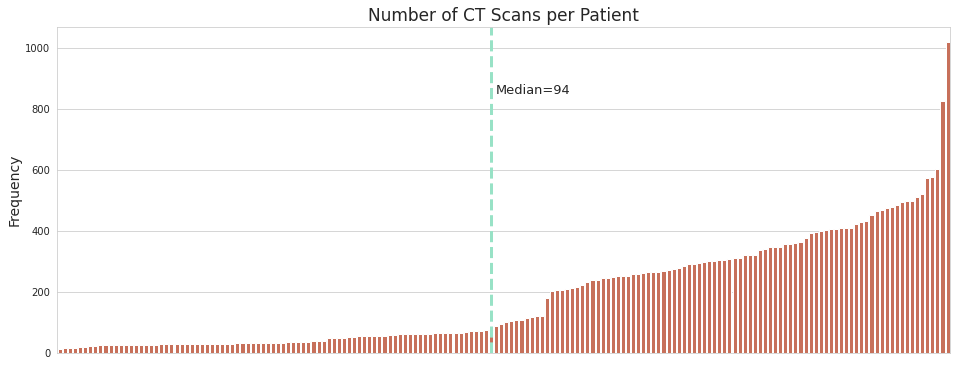

In [ ]:
print("Minimum number of CT scans: {}".format(train["CT_number"].min()), "\n" +
      "Maximum number of CT scans: {:,}".format(train["CT_number"].max()))

# Scans per Patient
data = train.groupby(by="Patient")["CT_number"].first().reset_index(drop=False)
# Sort by Weeks
data = data.sort_values(['CT_number']).reset_index(drop=True)

# Plot
plt.figure(figsize = (16, 6))
p = sns.barplot(data["Patient"], data["CT_number"], color=custom_colors[5])
plt.axvline(x=85, color=custom_colors[2], linestyle='--', lw=3)

plt.title("Number of CT Scans per Patient", fontsize = 17)
plt.xlabel('Patient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.text(86, 850, "Median=94", fontsize=13)

p.axes.get_xaxis().set_visible(False);

In [ ]:
class bcolors:
    OKBLUE = '\033[96m'
    OKGREEN = '\033[92m'

Patient id.......: ID00007637202177411956430 
Modality.........: CT 
Rows.............: 512 
Columns..........: 512


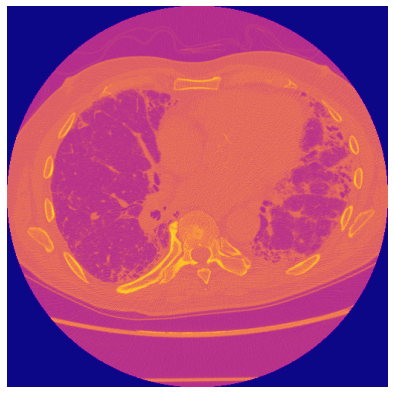

In [ ]:
path = "/content/train/ID00007637202177411956430/19.dcm"
dataset = pydicom.dcmread(path)

print(bcolors.OKBLUE + "Patient id.......:", dataset.PatientID, "\n" +
      "Modality.........:", dataset.Modality, "\n" +
      "Rows.............:", dataset.Rows, "\n" +
      "Columns..........:", dataset.Columns)

plt.figure(figsize = (7, 7))
plt.imshow(dataset.pixel_array, cmap="plasma")
plt.axis('off');

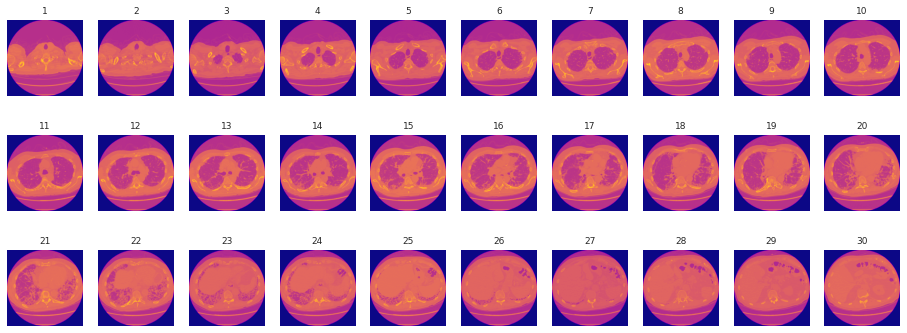

In [ ]:
patient_dir = "/content/train/ID00007637202177411956430"
datasets = []

# First Order the files in the dataset
files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm) 
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# Read in the Dataset
for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))

# Plot the images
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = datasets[i-1].pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="plasma")
    plt.title(i, fontsize = 9)
    plt.axis('off');

In [ ]:
from PIL import Image
from IPython.display import Image as show_gif
import scipy.misc
import matplotlib

def create_gif(number_of_CT = 87):
    """Picks a patient at random and creates a GIF with their CT scans."""
    
    # Select one of the patients
    # patient = "ID00007637202177411956430"
    patient = train[train["CT_number"] == number_of_CT].sample(random_state=1)["Patient"].values[0]
    
    # === READ IN .dcm FILES ===
    patient_dir = "/content/train/" + patient
    datasets = []

    # First Order the files in the dataset
    files = []
    for dcm in list(os.listdir(patient_dir)):
        files.append(dcm) 
    files.sort(key=lambda f: int(re.sub('\D', '', f)))

    # Read in the Dataset from the Patient path
    for dcm in files:
        path = patient_dir + "/" + dcm
        datasets.append(pydicom.dcmread(path))
        
        
    # === SAVE AS .png ===
    # Create directory to save the png files
    if os.path.isdir(f"png_{patient}") == False:
        os.mkdir(f"png_{patient}")

    # Save images to PNG
    for i in range(len(datasets)):
        img = datasets[i].pixel_array
        matplotlib.image.imsave(f'png_{patient}/img_{i}.png', img)
        
        
    # === CREATE GIF ===
    # First Order the files in the dataset (again)
    files = []
    for png in list(os.listdir(f"/content/png_{patient}")):
        files.append(png) 
    files.sort(key=lambda f: int(re.sub('\D', '', f)))

    # Create the frames
    frames = []

    # Create frames
    for file in files:
    #     print("../working/png_images/" + name)
        new_frame = Image.open(f"/content/png_{patient}/" + file)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(f'gif_{patient}.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=200, loop=0)

In [ ]:
create_gif(number_of_CT=12)
# create_gif(number_of_CT=30)
# create_gif(number_of_CT=87)

# print("First file len:", len(os.listdir("../working/png_ID00165637202237320314458")), "\n" +
#       "Second file len:", len(os.listdir("../working/png_ID00199637202248141386743")), "\n" +
#       "Third file len:", len(os.listdir("../working/png_ID00340637202287399835821")))

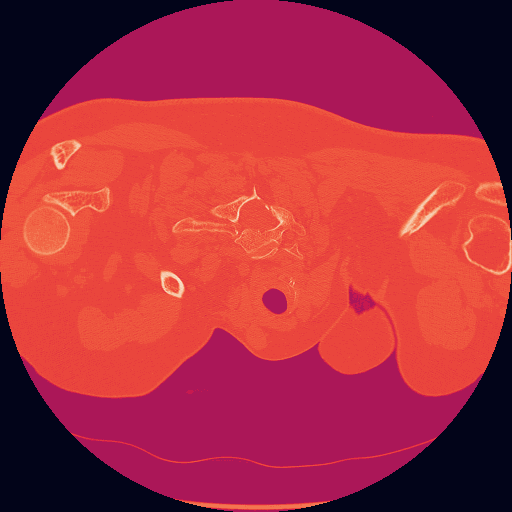

In [ ]:
show_gif(filename="./gif_ID00165637202237320314458.gif", format='png', width=400, height=400)

In [ ]:
"""
DICOM Lung Mask🎭
Mask on Lungs Purpose:

Segmentation is part of the preprocessing method
Has the purpose of auto-detecting the boundaries surrounding a volume of interest (our case is the lungs)
Drawbacks: be sure you don't exclude important parts (like lesions)

# https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
"""



def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
        # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0


    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

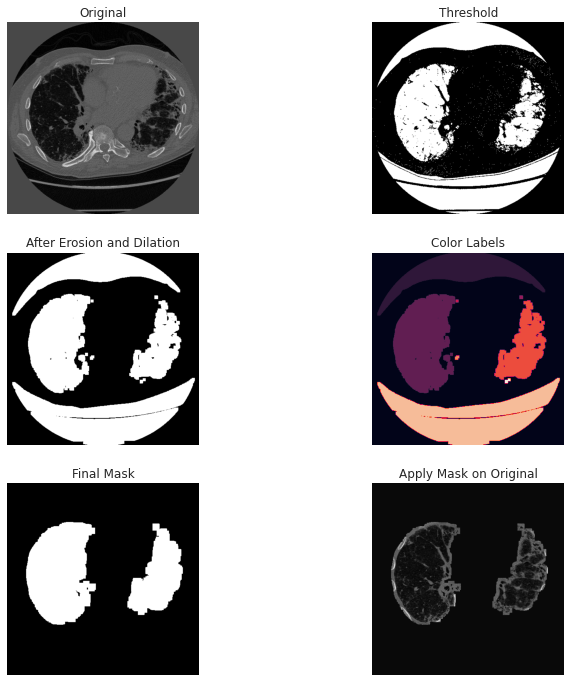

In [ ]:
#How does the mask work?
# Select a sample
path = "/content/train/ID00007637202177411956430/19.dcm"
dataset = pydicom.dcmread(path)
img = dataset.pixel_array

# Masked image
mask_img = make_lungmask(img, display=True)




Mask Images for one Patient
📌

Remember: Lungs are quite visible, but on images at the beginning and towards the end the lung dissapears completely.


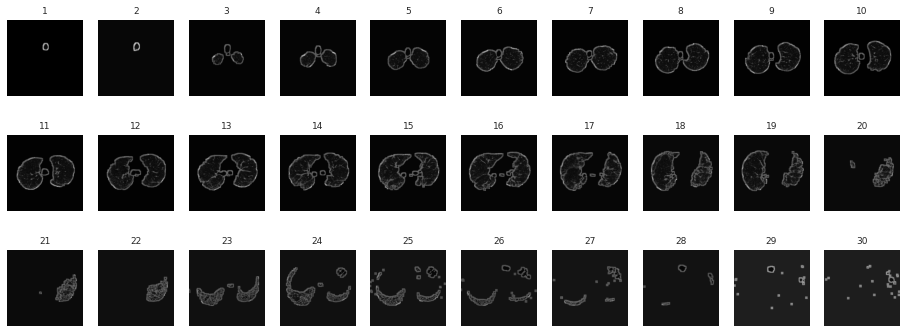

In [ ]:
patient_dir = "/content/train/ID00007637202177411956430"
datasets = []

# First Order the files in the dataset
files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm) 
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# Read in the Dataset
for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))
    
imgs = []
for data in datasets:
    img = data.pixel_array
    imgs.append(img)
    
    
# Show masks
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = make_lungmask(datasets[i-1].pixel_array)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.title(i, fontsize = 9)
    plt.axis('off');

4. 🏃‍♂️RAPIDS - crazy fast🏃‍♂️

In this part we will use rapids.ai to extract and preprocess the metadata from the dicom files as well as the data available in the train.csv.


In [ ]:
# https://www.kaggle.com/cdeotte/rapids

import sys
!cp /content/rapids/rapids.0.14.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/content/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/content/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/content/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

cp: cannot stat '/content/rapids/rapids.0.14.0': No such file or directory
/bin/bash: line 0: cd: /opt/conda/envs/: No such file or directory
cp: cannot stat '/opt/conda/envs/rapids/lib/libxgboost.so': No such file or directory


In [ ]:
def get_observation_data(path):
    '''Get information from the .dcm files.
    path: complete path to the .dcm file'''

    image_data = pydicom.read_file(path)

    # Dictionary to store the information from the image
    observation_data = {
        "FileNumber" : path.split('/'),
        "Rows" : image_data.Rows,
        "Columns" : image_data.Columns,

        "PatientID" : image_data.PatientID,
        "BodyPartExamined" : image_data.BodyPartExamined,
        "SliceThickness" : int(image_data.SliceThickness),
        "KVP" : int(image_data.KVP),
        "DistanceSourceToDetector" : int(image_data.DistanceSourceToDetector),
        "DistanceSourceToPatient" : int(image_data.DistanceSourceToPatient),
        "GantryDetectorTilt" : int(image_data.GantryDetectorTilt),
        "TableHeight" : int(image_data.TableHeight),
        "RotationDirection" : image_data.RotationDirection,
        "XRayTubeCurrent" : int(image_data.XRayTubeCurrent),
        "GeneratorPower" : int(image_data.GeneratorPower),
        "ConvolutionKernel" : image_data.ConvolutionKernel,
        "PatientPosition" : image_data.PatientPosition,

        "ImagePositionPatient" : str(image_data.ImagePositionPatient),
        "ImageOrientationPatient" : str(image_data.ImageOrientationPatient),
        "PhotometricInterpretation" : image_data.PhotometricInterpretation,
        "ImageType" : str(image_data.ImageType),
        "PixelSpacing" : str(image_data.PixelSpacing),
        "WindowCenter" : int(image_data.WindowCenter),
        "WindowWidth" : int(image_data.WindowWidth),
        "Modality" : image_data.Modality,
        "StudyInstanceUID" : image_data.StudyInstanceUID,
        "PixelPaddingValue" : image_data.PixelPaddingValue,
        "SamplesPerPixel" : image_data.SamplesPerPixel,
        "SliceLocation" : int(image_data.SliceLocation),
        "BitsAllocated" : image_data.BitsAllocated,
        "BitsStored" : image_data.BitsStored,
        "HighBit" : image_data.HighBit,
        "PixelRepresentation" : image_data.PixelRepresentation,
        "RescaleIntercept" : int(image_data.RescaleIntercept),
        "RescaleSlope" : int(image_data.RescaleSlope),
        "RescaleType" : image_data.RescaleType
    }
    
    return observation_data

Test the function to see if it works
❗

Note: function skips patients if they do not have 1 or more of the attributes listed above. Will be changed accordingly in future versions.

In [ ]:
p = "/content/train/ID00007637202177411956430/10.dcm"
example = get_observation_data(p)

# example

In [ ]:
# Get full paths for the images
paths = []
for path in train["Path"]:
    for doc in os.listdir(path):
        paths.append(path + "/" + doc)
        
# How many paths?
print("There are {:,} paths in total.".format(len(paths)))

There are 289,826 paths in total.


In [ ]:
import tqdm
meta_train_data = []
exceptions = 0

for path in tqdm.tqdm(paths):
    try:
        meta_train_data.append(get_observation_data(path))
        
    except Exception as e:
        exceptions += 1
        continue

100%|██████████| 289826/289826 [17:58<00:00, 268.77it/s]
